# **Model 3**

In [1]:
from google.colab import drive  
drive.mount("/content/drive", force_remount = True)

Mounted at /content/drive


### **Importing the libraries**

In [2]:
# utility libs
from tqdm import tqdm, tqdm_notebook
from time import time

# data handling
import numpy as np
import pandas as pd
from scipy import stats

# data visualization libs
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns

# machine learning libs
import keras
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers import GRU, LSTM, SimpleRNN, Embedding, Dense, Dropout, SpatialDropout1D, Dropout, Conv1D, MaxPooling1D, Flatten, Input, concatenate
from keras import optimizers, activations
from keras import backend as K
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.regularizers import l1, l2, l1_l2

In [3]:
dir = '/content/drive/MyDrive/AML/'

In [4]:
x_train = pd.read_csv(dir+'x_train2.csv', index_col=0)

In [5]:
x_train.head()

,name,item_condition_id,brand_name,price,shipping,item_description,general_cat,subcat_1,subcat_2
0,razer blackwidow chroma keyboard,3,3876,3.951244,0,keyboard is great condition works like came bo...,249,189,188
1,ava viv blouse,1,4572,2.302585,1,adorable top hint lace key hole pale pink is h...,752,683,80
2,acacia pacific tides santorini top,3,84,4.158883,0,size small straps slightly shortened fit xs be...,752,652,715
3,girls cheer tumbling bundle,3,4326,1.791759,1,get three pairs sophie cheer shorts size small...,619,17,301
4,girls nike pro shorts,3,3325,2.944439,0,girls size small plus green three shorts total,619,17,301


In [6]:
x_train, x_val, y_train, y_val = train_test_split(x_train.drop(columns='price', axis=1), x_train.price, test_size=0.2)

### **Converting words to indexes**

In order to convert every word to an array of indexes we must build the vocabulary using keras tokenizer.

In [7]:
item_description_train = x_train.item_description.values
name_train = x_train.name.values

item_description_val = x_val.item_description.values
name_val = x_val.name.values

In [8]:
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(list(item_description_train) + list(name_train))

vocab_size = len(tokenizer.word_index) + 1
vocab_size

90397

A common problem that arises when mapping to sequences is the choice of the vector's length, which has not to be neither too short or too long and must fit at most the sentences. According to the previous histograms, we decide to pad *item_description* up to 30 numbers (around ~85% of the distribution) and *name* up to 8 numbers.

In [9]:
encoded_item_description_train = tokenizer.texts_to_sequences(list(item_description_train))
encoded_name_train = tokenizer.texts_to_sequences(list(name_train))

padded_train_sequences_item_description = pad_sequences(encoded_item_description_train, padding = 'post', maxlen = 30)
padded_train_sequences_name = pad_sequences(encoded_name_train, padding = 'post', maxlen = 8)

In [10]:
encoded_item_description_val = tokenizer.texts_to_sequences(list(item_description_val))
encoded_name_val = tokenizer.texts_to_sequences(list(name_val))

padded_val_sequences_item_description = pad_sequences(encoded_item_description_val, padding = 'post', maxlen = 30)
padded_val_sequences_name = pad_sequences(encoded_name_val, padding = 'post', maxlen = 8)

In [11]:
print(padded_train_sequences_item_description.shape)
print(padded_train_sequences_name.shape)

(675844, 30)
(675844, 8)


### **Building the model**

In [12]:
keras.backend.clear_session()

######### define the sets of input #########
inputA = Input(shape=(8,))
inputB = Input(shape=(30,))
inputC = Input(shape=(1,))
inputD = Input(shape=(1,))
inputE = Input(shape=(1,))
inputF = Input(shape=(1,))
inputG = Input(shape=(1,))
inputH = Input(shape=(1,))

###############################################################
################## CATEGORICAL DATA ###########################
###############################################################

######### name #########
x = Embedding(vocab_size, output_dim = 8, input_length=padded_train_sequences_name.shape[1])(inputA)
x = Conv1D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
x = MaxPooling1D()(x)
x = Dropout(0.01)(x)
x = GRU(64,dropout=0.5)(x)
x = Model(inputs=inputA, outputs=x)

######### item_description #########
y = Embedding(vocab_size, output_dim = 30, input_length=padded_train_sequences_item_description.shape[1])(inputB)
y = Conv1D(128, 3, padding='same', activation='relu', kernel_regularizer=l2(0.01))(y)
y = MaxPooling1D()(y)
y = Dropout(0.01)(y)
y = GRU(64,dropout=0.5)(y)
y = Model(inputs=inputB, outputs=y)

######### combine the output of the two branches #########
categorical = concatenate([x.output, y.output])

###############################################################
###################### NUMERIC DATA ###########################
###############################################################

######### item_condition_id #########
u = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(inputC)
u = Dropout(0.01)(u)
u = Dense(16, activation='relu')(u)
u = Model(inputs=inputC, outputs=u)

######### brand_name #########
w = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(inputD)
w = Dropout(0.01)(w)
w = Dense(16, activation='relu')(w)
w = Model(inputs=inputD, outputs=w)

######### shipping #########
v = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(inputE)
v = Dropout(0.01)(v)
v = Dense(16, activation='relu')(v)
v = Model(inputs=inputE, outputs=v)

######### general_cat #########
c1 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(inputF)
c1 = Dropout(0.01)(c1)
c1 = Dense(16, activation='relu')(c1)
c1 = Model(inputs=inputF, outputs=c1)

######### subcat_1 #########
c2 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(inputG)
c2 = Dropout(0.01)(c2)
c2 = Dense(16, activation='relu')(c2)
c2 = Model(inputs=inputG, outputs=c2)

######### subcat_2 #########
c3 = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(inputH)
c3 = Dropout(0.01)(c3)
c3 = Dense(16, activation='relu')(c3)
c3 = Model(inputs=inputH, outputs=c3)

######### combine the output of numerical data #########
numerical = concatenate([u.output, w.output, v.output, c1.output, c2.output, c3.output])

combined = concatenate([categorical, numerical])

# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(128, activation="relu", kernel_regularizer=l2(0.01))(combined)
z = Dropout(0.01)(z)
z = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(z)
z = Dropout(0.01)(z)
z = Dense(16, activation='relu', kernel_regularizer=l2(0.01))(z)
z = Flatten()(z)
z = Dense(1, activation="linear")(z)

# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[x.input, y.input, u.input, w.input, v.input, c1.input, c2.input, c3.input], outputs=z)

model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 30)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 8, 8)         723176      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 30, 30)       2711910     input_2[0][0]                    
____________________________________________________________________________________________

In [13]:
model.compile(metrics=['mse', 'mae', 'mape'], loss="mean_squared_error", optimizer='adam')

In [14]:
n_epochs = 25
es = EarlyStopping(monitor='val_mse', mode = 'min', min_delta=0.005, verbose=1, patience=5, restore_best_weights=True)
history = model.fit(x=[padded_train_sequences_name, padded_train_sequences_item_description, x_train.item_condition_id.values, x_train.brand_name.values, x_train.shipping.values, x_train.general_cat.values, x_train.subcat_1.values, x_train.subcat_2.values], y=y_train, verbose=1, validation_split = 0.2, epochs=n_epochs, batch_size=128, callbacks = [es])

Epoch 1/25
4225/4225 [==============================] - 387s 90ms/step - loss: 5.8751 - mse: 4.7563 - mae: 0.9038 - mape: 31.6462 - val_loss: 0.8699 - val_mse: 0.3090 - val_mae: 0.4190 - val_mape: 14.7704
Epoch 2/25
4225/4225 [==============================] - 378s 90ms/step - loss: 0.7915 - mse: 0.3076 - mae: 0.4208 - mape: 14.9237 - val_loss: 0.5687 - val_mse: 0.3048 - val_mae: 0.4147 - val_mape: 14.2012
Epoch 3/25
4225/4225 [==============================] - 380s 90ms/step - loss: 0.4898 - mse: 0.2872 - mae: 0.4057 - mape: 14.3878 - val_loss: 0.3580 - val_mse: 0.2937 - val_mae: 0.4097 - val_mape: 14.8832
Epoch 4/25
4225/4225 [==============================] - 374s 88ms/step - loss: 0.3172 - mse: 0.2716 - mae: 0.3934 - mape: 13.9741 - val_loss: 0.3136 - val_mse: 0.2907 - val_mae: 0.4094 - val_mape: 15.0324
Epoch 5/25
4225/4225 [==============================] - 379s 90ms/step - loss: 0.2834 - mse: 0.2608 - mae: 0.3853 - mape: 13.7000 - val_loss: 0.3133 - val_mse: 0.2917 - val_mae: 0.

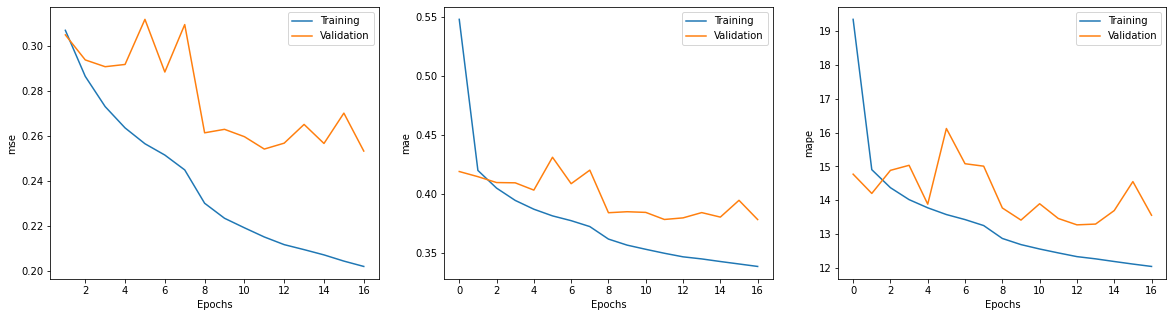

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))
(ax1, ax2, ax3) = axs

ax1.plot(list(range(1, len(history.history['loss']))), history.history['mse'][1:])
ax1.plot(list(range(1, len(history.history['loss']))), history.history['val_mse'][1:])

ax2.plot(list(range(0, len(history.history['loss']))), history.history['mae'])
ax2.plot(list(range(0, len(history.history['loss']))), history.history['val_mae'])

ax3.plot(list(range(0, len(history.history['loss']))), history.history['mape'])
ax3.plot(list(range(0, len(history.history['loss']))), history.history['val_mape'])

ax1.legend(['Training', 'Validation']); ax2.legend(['Training', 'Validation']); ax3.legend(['Training', 'Validation'])

ax1.set(xlabel='Epochs', ylabel='mse'); ax2.set(xlabel='Epochs', ylabel='mae'); ax3.set(xlabel='Epochs', ylabel='mape')

plt.show()

In [16]:
model.evaluate([padded_val_sequences_name, padded_val_sequences_item_description, x_val.item_condition_id.values, x_val.brand_name.values, x_val.shipping.values, x_val.general_cat.values, x_val.subcat_1.values, x_val.subcat_2.values], y_val)

5281/5281 [==============================] - 29s 5ms/step - loss: 0.2697 - mse: 0.2517 - mae: 0.3771 - mape: 13.4215


[0.26971110701560974,
 0.2517019510269165,
 0.3771023452281952,
 13.421472549438477]

In [17]:
y_pred_log_scale = model.predict(x=[padded_val_sequences_name, padded_val_sequences_item_description, x_val.item_condition_id.values, x_val.brand_name.values, x_val.shipping.values, x_val.general_cat.values, x_val.subcat_1.values, x_val.subcat_2.values], verbose=1, workers=2)
y_pred_log_scale = list(map(lambda x: x[0], y_pred_log_scale))

5281/5281 [==============================] - 28s 5ms/step


In [18]:
y_pred = np.exp(y_pred_log_scale)
y_pred

array([70.08105  , 14.907416 , 16.999384 , ..., 11.284565 , 26.119713 ,
       11.6852455], dtype=float32)

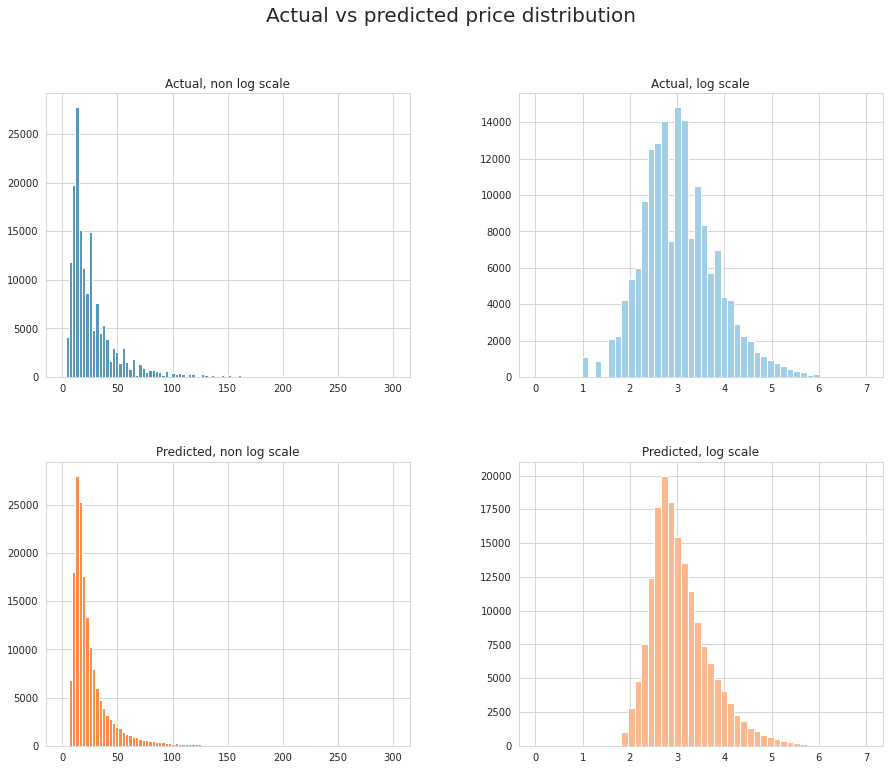

In [19]:
with sns.axes_style("whitegrid"):
  fig, axs = plt.subplots(2, 2, figsize = (15, 12), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
  (ax1, ax2), (ax3, ax4) = axs

  fig.suptitle('Actual vs predicted price distribution', fontsize = 20)

  ax1.hist(np.exp(y_val), bins = 100, color="#5998BA", range = [0, 300])
  ax1.set_title('Actual, non log scale')

  ax2.hist(y_val, bins = 50, color='#A1CFE8', range = [0, 7])
  ax2.set_title('Actual, log scale')

  ax3.hist(y_pred, bins = 100, color='#FC8D49', range = [0, 300])
  ax3.set_title('Predicted, non log scale')

  ax4.hist(y_pred_log_scale, bins = 50, color='#FFB88D', range = [0, 7])
  ax4.set_title('Predicted, log scale')

plt.show()

In [20]:
print('Predicted non-log stats: \n', stats.describe(y_pred))
print('\nActual non-log stats: \n', stats.describe(np.exp(y_val)))

print('\nPredicted log stats: \n', stats.describe(y_pred_log_scale))
print('\nActual log stats: \n', stats.describe(y_val))

Predicted non-log stats: 
 DescribeResult(nobs=168961, minmax=(7.067785, 390.6841), mean=27.10635, variance=696.4628, skewness=4.382314682006836, kurtosis=27.919098923378463)

Actual non-log stats: 
 DescribeResult(nobs=168961, minmax=(3.0000000000000004, 2006.000000000001), mean=31.03335089162588, variance=2108.0875743828465, skewness=11.368044851702797, kurtosis=265.6954764782903)

Predicted log stats: 
 DescribeResult(nobs=168961, minmax=(1.9555471, 5.9678993), mean=3.0617912, variance=0.3844571, skewness=0.9822748899459839, kurtosis=1.1837826608053277)

Actual log stats: 
 DescribeResult(nobs=168961, minmax=(1.0986122886681098, 7.603897968521881), mean=3.0558748111600225, variance=0.6207796530893676, skewness=0.6307475848672913, kurtosis=0.9195985062255478)


Results can be compared by confronting the actual vs predicted density plot.

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning:

Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



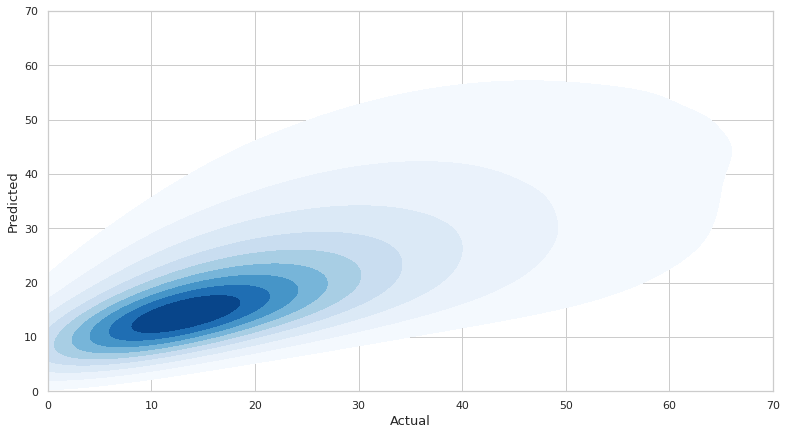

In [ ]:
start = time()

sns.set(rc={'figure.figsize':(13,7)})
sns.set_style("whitegrid")

sns.kdeplot(np.exp(y_val), y_pred, cmap="Blues", shade=True, thresh=0.05, clip=(0.0, 70.0))
plt.xlabel('Actual', fontsize=13)
plt.ylabel('Predicted', fontsize=13)
plt.show()

print('\nExecution time:', time()-start)

In [ ]:
np.savetxt(dir+"model3_output.csv", y_pred_log_scale, delimiter=",")

### **Predicting the target data**

In [ ]:
x_test = pd.read_csv(dir + 'x_test2.csv', index_col=0)
x_test.head()

In [24]:
item_description_test = x_test.item_description.values
name_test = x_test.name.values

encoded_item_description_test = tokenizer.texts_to_sequences(list(item_description_test))
encoded_name_test = tokenizer.texts_to_sequences(list(name_test))

padded_test_sequences_item_description = pad_sequences(encoded_item_description_test, padding = 'post', maxlen = 30)
padded_test_sequences_name = pad_sequences(encoded_name_test, padding = 'post', maxlen = 8)

In [25]:
y_pred_log_scale = model.predict(x=[padded_test_sequences_name, padded_test_sequences_item_description, x_test.item_condition_id.values, x_test.brand_name.values, x_test.shipping.values, x_test.general_cat.values, x_test.subcat_1.values, x_test.subcat_2.values], verbose=1, workers=2)
y_pred_log_scale = list(map(lambda x: x[0], y_pred_log_scale))

12365/12365 [==============================] - 65s 5ms/step


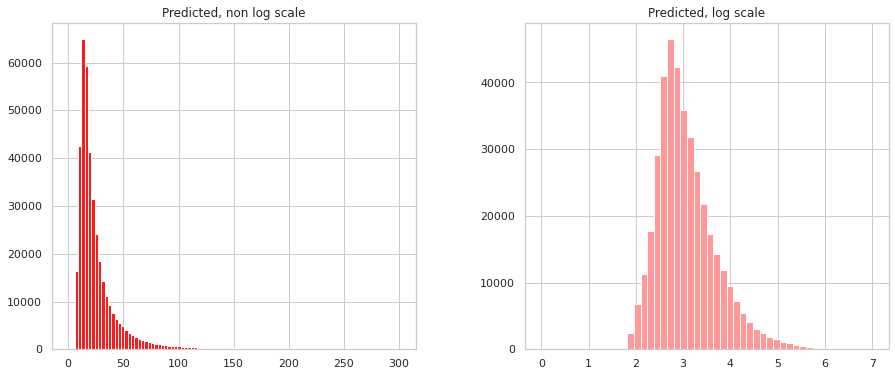

In [29]:
with sns.axes_style("whitegrid"):
  fig, axs = plt.subplots(1, 2, figsize = (15, 6), gridspec_kw={'hspace': 0.3, 'wspace': 0.3})
  (ax1, ax2) = axs

  ax1.hist(np.exp(y_pred_log_scale), bins = 100, color="#ff1a1a", range = [0, 300])
  ax1.set_title('Predicted, non log scale')

  ax2.hist(y_pred_log_scale, bins = 50, color='#ff9999', range = [0, 7])
  ax2.set_title('Predicted, log scale')

plt.show()

In [28]:
print('Predicted non-log stats: \n', stats.describe(np.exp(y_pred_log_scale)))
print('\nPredicted log stats: \n', stats.describe(y_pred_log_scale))

Predicted non-log stats: 
 DescribeResult(nobs=395678, minmax=(7.067785, 388.73624), mean=27.088078, variance=696.26733, skewness=4.417739391326904, kurtosis=28.497077739422892)

Predicted log stats: 
 DescribeResult(nobs=395678, minmax=(1.9555471, 5.962901), mean=3.0612211, variance=0.3845923, skewness=0.976279079914093, kurtosis=1.1816178135491668)
